# Simulated annealing Demo 3

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

#%matplotlib notebook

In [2]:
import sys

sys.path.insert(0, "../../src")

In [3]:
from IPython.display import clear_output, display

In [4]:
def _display_progress(current_progress, progress):
        idx = np.where(progress - current_progress >= 0)[0][0] + 1
        perc = int(100. * idx / progress.shape[0])
        clear_output(wait = True)
        prg = "["
        prg += "".join(["=" for i in range(int(perc / 5))])
        prg += "".join(["." for i in range(20 - int(perc / 5))])
        prg += "".join("]")
        display(prg + "       " + 'Progress: ' + str(perc) + "%")

In [5]:
from env.light_grid import LightGrid
from walker.light_walker import LightWalker
from walker.simulated_annealing import SimulatedAnnealing

In [6]:
x_l, x_r = -10, 10
y_l, y_r = -10, 10

In [7]:
def global_optimizer(x, y):
    return 1 / 1000 * (10 - x * np.sin(0.01 * x + y) + y ** 2 * np.cos(x) + x * y * np.sin(x + y))

In [8]:
xx = np.linspace(x_l, x_r, 100)
yy = np.linspace(y_l, y_r, 100)

X, Y = np.meshgrid(xx, yy)

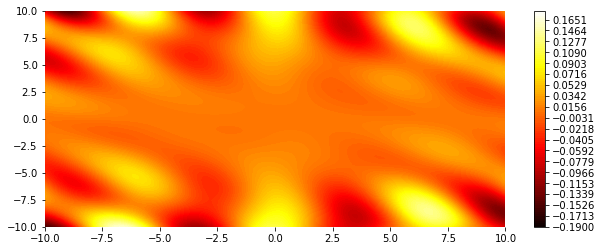

In [25]:
cmap = plt.get_cmap('hot')

levels = np.linspace(-0.19, 0.18, 100)

fig = plt.figure()

fig.set_figheight(3)
fig.set_figwidth(8)

ax = fig.add_axes([0, 0, 1, 1], frameon=False)

cs = ax.contourf(X, Y, global_optimizer(X, Y), levels, cmap = cmap)
c_bar = fig.colorbar(cs, ticks = levels[::5])

ax.set_xlim(-10, 10)
ax.set_ylim(-10, 10)

plt.show()

In [10]:
annealing = SimulatedAnnealing(initial_temperature = 1000, temperature_decay = 0.99)

In [11]:
grid = LightGrid(bounded = True, bounds = [(x_l, x_r), (y_l, y_r)], dr = np.ones(2) * 1e-2, dim = 2)
grid.add_processor(global_optimizer, name = "optimizer")

In [13]:
no_of_walkers = 100
no_of_steps = int(1e2)
frames = np.linspace(0, no_of_steps, no_of_steps)

def get_initial_coordinates(no, x_bounds, y_bounds):
    return np.random.uniform(low = x_bounds[0], high = x_bounds[1], size = no),\
            np.random.uniform(low = y_bounds[0], high = y_bounds[1], size = no)

In [14]:
walkers = []

In [15]:
coordinates = get_initial_coordinates(no_of_walkers, (-10, 10), (-10, 10))

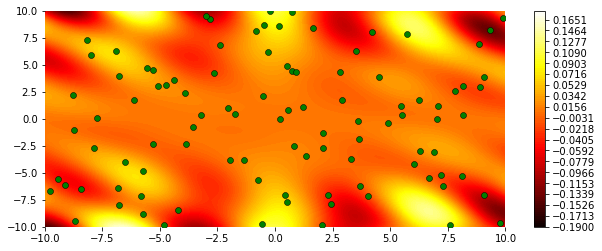

In [22]:
scat = ax.scatter(coordinates[0], coordinates[1], c = 'g', edgecolor = 'k', lw=0.5)
fig

In [36]:
def _init():
    #scat.set_offsets(list([coordinates[0][i], coordinates[1][i]] for i in range(no_of_walkers)))
    scat.set_offsets(np.transpose(coordinates))
    return scat,

(100, 2)

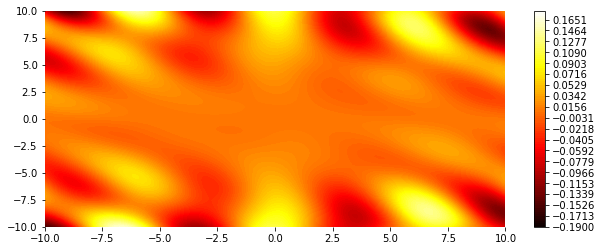

In [37]:
_init()

#plt.show()

fig

In [40]:
for i in range(no_of_walkers):
    wlk = LightWalker(dim = 2, \
                 data_collection_keys = ['optimizer'], \
                 max_no_of_steps = no_of_steps, \
                 initial_position = np.array([coordinates[0][i], coordinates[1][i]]), \
                 next_step_processor = annealing)
    walkers.append(wlk)

In [41]:
drs = [np.ones(2, dtype = np.float64) * 1e-1, \
       np.ones(2, dtype = np.float64) * 1e-2, \
       np.ones(2, dtype = np.float64) * 1e-3, \
       np.ones(2, dtype = np.float64) * 1e-4]

In [42]:
from random import choice

In [43]:
prg = np.linspace(0, no_of_steps, no_of_steps)

global_min = 1e5
coord_min = (0, 0)

In [47]:
def animation_(i, fg, sc):
    coords = []
    next_positions = 0
    if i < no_of_steps:
        for walker in walkers:
            curr = walker.get_current_position()
            data_collector = list(key for key in walker.data.keys())[0]
            dr = choice(drs)
            next_positions = grid._next(curr, dr = dr)
            eng_curr = grid.processors[data_collector](curr[0], curr[1])
            eng_next = np.array([grid.processors[data_collector](next_pos[0], next_pos[1]) for next_pos in next_positions])
            walker.walk(possible_states = next_positions, energies = eng_next, current_energy = eng_curr)
            tmp = walker.get_current_position()
            coords.append(tmp)
            if global_optimizer(tmp[0], tmp[1]) < global_min:
                coord_min = curr
                global_min = global_optimizer(tmp[0], tmp[1])
        coords = np.array(coords)
        sc.set_sizes(100)
        sc.set_edgecolors('k')
        sc.set_offsets(coords)
        #_display_progress(i, prg)
    
    return sc,


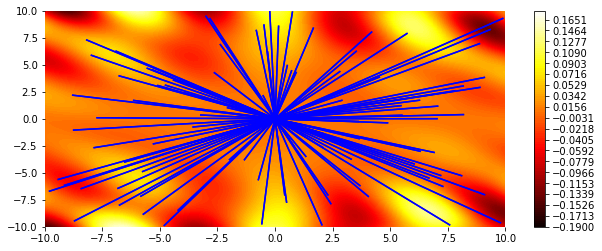

In [49]:
anime = animation.FuncAnimation(fig, animation_, interval=1, frames = np.linspace(0, no_of_steps, no_of_steps), init_func = _init, fargs = (fig, scat), blit=True, save_count=50)

plt.show()
fig

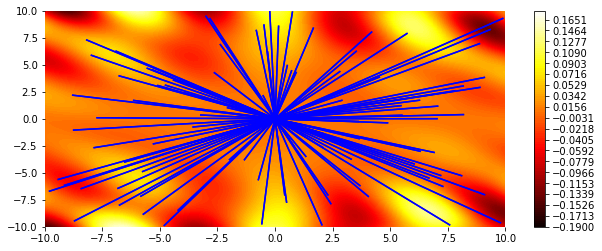

In [46]:
for wlk in walkers:
    ax.plot(wlk.visited[:, 0], wlk.visited[:, 1], c = 'b')
fig